# Hotel Demands Analytic 
### Created By : Alhuda Reza Mahara

## Business Problem Understanding

**Context**

Sebuah perusahaan yang bergerak di bidang perhotelan ingin mengetahui dan mengatasi permasalahan yang menyebabkan para konsumen melakukan pembatalan pesanan hotel.

Target :

0 : Konsumen tidak melakukan pembatalan pesanan hotel

1 : Konsumen melakukan pembatalan pesanan hotel


**Problem Statement :**

Pembatalan pesanan hotel yang dilakukan oleh konsumen dapat menyebabkan opportunity lost yang diakibatkan karena kamar yang harusnya ditempati tapi tidak jadi ditempati oleh konsumen.

**Goals :**

Maka berdasarkan permasalahan tersebut, ingin memiliki kemampuan untuk memprediksi kemungkinan konsumen melakukan pembatalan pesanan hotel, sehingga perusahaan dapat memfokuskan sumber daya yang ada pada pesanan yang memiliki potensi yang lebih besar untuk tidak melakukan pembatalan pesanan dan tetap menjaga kepercayaan konsumen.

dan juga, perusahaan ingin mengetahui apa yang membuat konsumen akan melakukan pembatalan pesanan hotel atau tidak, sehingga perusahaan dapat membuat rencana yang lebih baik dalam mengurangi pembatalan pesanan yang dilakukan oleh konsumen.

**Analytic Approach :**

Yang akan kita lakukan adalah melakukan analisis data untuk menemukan pola yang membedakan pesanan yang berpotensi dibatalkan oleh konsumen.

kemudian kita akan membangun model klasifikasi yang akan membantu perusahaan perhotelan untuk dapat memprediksi probabilitas konsumen yang akan membatalkan pesanannya atau tidak.

**Metric Evaluation**

<img src='matrix.jpg'>

Type 1 error : False Positive  
Konsekuensi: Kehilangan kepercayaan konsumen

Type 2 error : False Negative  
Konsekuensi: potensi kehilangan konsumen potensial (Banyak Kamar Kosong)

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengurangi potensi kehilangan konsumen potensial, tetapi tanpa menimbulkan efek kehilangan kepercayaan konsumen. Jadi pada kasus kali ini kita akan mencoba menyeimbangkan hasil dari precision dan recallnya menggunakan matriks F1-Score dari kelas positive (is_canceled). Jadi nanti metric utama yang akan kita gunakan adalah F1-Score.

### Data Understanding

Dataset Source : https://drive.google.com/file/d/1eeXOEY5B_zfSNhWeDDqPWCo9hAyDRAbc/view?usp=sharing

Note :

   - Data Tidak Seimbang
   - Sebagian data bersifat kategorikal
   - Setiap baris data merepresentasikan informasi pesanan Hotel


### Attribute Information

### Attribute Information

| Attribute | Data Type, Length | Description |
| --- | --- | --- |
| country | Text | Country Code |
| market_segment | Text | Market segment designation. In categories, the term “TA” means “Travel Agents” and “TO” means “Tour Operators” |
| previous_cancellations | Long | Number of previous bookings that were cancelled by the customer prior to the current booking |
| booking_changes | long | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS |
| deposit_type | Text | Indication on if the customer made a deposit to guarantee the booking. This variable can assume three categories |
| days_in_waiting_list | long | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type | Text | Type of booking, assuming one of four categories |
| reserved_room_type | Text | Code of room type reserved. Code is presented instead of designation for anonymity reasons. |
| required_car_parking_spaces | Long | Number of car parking spaces required by the customer |
| total_of_special_requests | long | Number of special requests made by the customer  |
| is_canceled | long | Value indicating if the booking was canceled (1) or not (0) |


In [2]:
# Library

import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from IPython.display import display

# Feature Engineering
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from category_encoders import BinaryEncoder

# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, f1_score

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.combine import SMOTETomek

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('data_hotel_booking_demand.csv')
df

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


## Data Cleaning

Ada data yang hilang/kosong di kolom country, maka kita akan menghandle data yang hilang/kosong  dan membuatnya menjadi siap pakai untuk melakukan analisa terhadap masalahnya dan juga pembuatan model machine learningnya.

### Missing Values

In [5]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,351,0.42,162,"[CYP, ISL]"
1,market_segment,object,0,0.00,8,"[Offline TA/TO, Complementary]"
2,previous_cancellations,int64,0,0.00,15,"[5, 6]"
3,booking_changes,int64,0,0.00,19,"[6, 8]"
4,deposit_type,object,0,0.00,3,"[No Deposit, Non Refund]"
5,days_in_waiting_list,int64,0,0.00,115,"[150, 107]"
6,customer_type,object,0,0.00,4,"[Group, Transient-Party]"
7,reserved_room_type,object,0,0.00,10,"[A, C]"
8,required_car_parking_spaces,int64,0,0.00,5,"[0, 1]"
9,total_of_special_requests,int64,0,0.00,6,"[5, 0]"


Dapat dilihat bahwa pada diatas bahwa format dari setiap kolom sudah benar, walaupun begitu terdapat kolom yang memiliki missing value.

In [6]:
df.isna().sum()

country                        351
market_segment                   0
previous_cancellations           0
booking_changes                  0
deposit_type                     0
days_in_waiting_list             0
customer_type                    0
reserved_room_type               0
required_car_parking_spaces      0
total_of_special_requests        0
is_canceled                      0
dtype: int64

<AxesSubplot:>

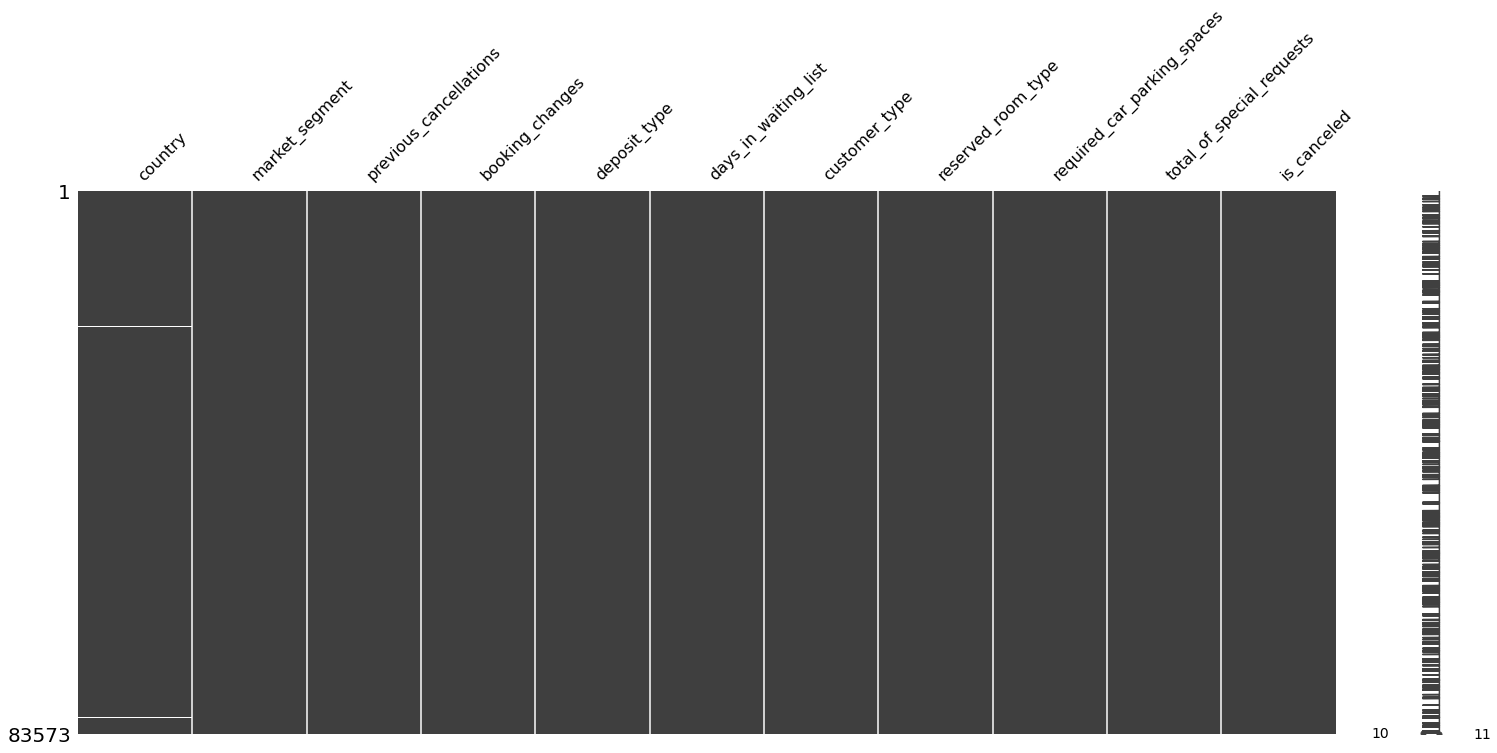

In [7]:
missingno.matrix(df)

Dapat dilihat bahwa missing value/data yang hilang pada kolom country memiliki pola yang acak

**Missing Value Handling**

Karena data bersifat kategorikal maka kita akan menggunakan modus untuk mengisi missing value.

In [8]:
eda_hotel = df.copy()
eda_hotel

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0


In [9]:
# Missing value handling
mode_imputer = SimpleImputer(strategy='most_frequent')
eda_hotel['country'] = mode_imputer.fit_transform(eda_hotel[['country']])

Lalu kita mengecek ulang data yang sudah di Impute.

In [10]:
listItem = []
for col in eda_hotel.columns :
    listItem.append([col, eda_hotel[col].dtype, eda_hotel[col].isna().sum(), round((eda_hotel[col].isna().sum()/len(eda_hotel[col])) * 100,2),
                    eda_hotel[col].nunique(), list(eda_hotel[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,0,0.0,162,"[ISR, PRT]"
1,market_segment,object,0,0.0,8,"[Complementary, Corporate]"
2,previous_cancellations,int64,0,0.0,15,"[26, 21]"
3,booking_changes,int64,0,0.0,19,"[13, 0]"
4,deposit_type,object,0,0.0,3,"[Non Refund, Refundable]"
5,days_in_waiting_list,int64,0,0.0,115,"[96, 62]"
6,customer_type,object,0,0.0,4,"[Contract, Transient]"
7,reserved_room_type,object,0,0.0,10,"[F, P]"
8,required_car_parking_spaces,int64,0,0.0,5,"[8, 3]"
9,total_of_special_requests,int64,0,0.0,6,"[2, 4]"


## Data Analysis

Text(0.5, 1.0, 'Top Ten Negara Pemesan Hotel')

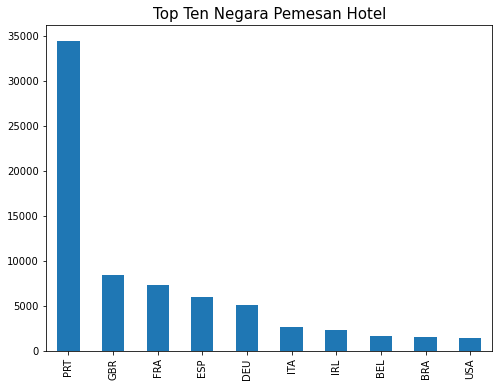

In [11]:
# Top ten Negara asal pemesan Hotel
plt.figure(figsize=(8,6))
eda_hotel['country'].value_counts().head(10).plot(kind='bar')
plt.title('Top Ten Negara Pemesan Hotel', size=15)

Text(0.5, 1.0, 'Data Cancel berdasarkan tipe deposit')

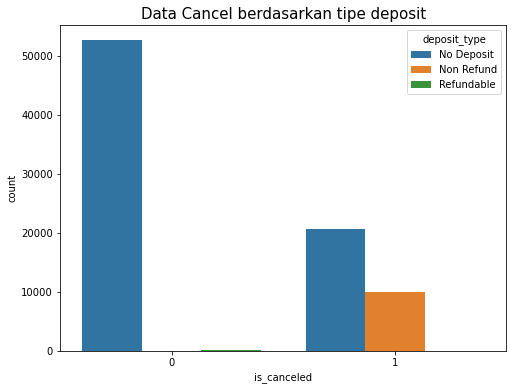

In [12]:
# Data Cancel berdasarkan tipe deposit
plt.figure(figsize=(8,6))
sns.countplot(x='is_canceled', hue='deposit_type', data=eda_hotel)
plt.title('Data Cancel berdasarkan tipe deposit', size=15)

Text(0.5, 1.0, 'Hubungan Tipe Konsumen dengan jumlah pembatalan')

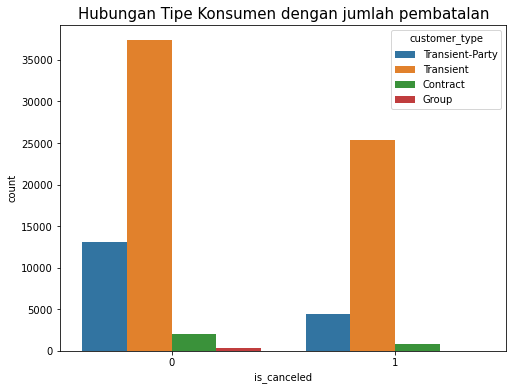

In [13]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'is_canceled', hue = 'customer_type', data = eda_hotel)
plt.title ('Hubungan Tipe Konsumen dengan jumlah pembatalan', size=15)

Tipe konsumen Transient Party merupakan Konsumen yang memiliki jumlah pembatalan yang paling tinggi disusul dengan tipe konsumen Transient, walaupun begitu kedua tipe tersebut juga menunjukan pola data yang kurang lebih sama dengan data pelanggan yang tidak melakukan pembatalan,sehingga Tipe konsumen tidak menentukan apakah konsumen melakukan pembatalan pesanan atau tidak.

Text(0.5, 1.0, 'Hubungan Segmen market dengan jumlah pembatalan')

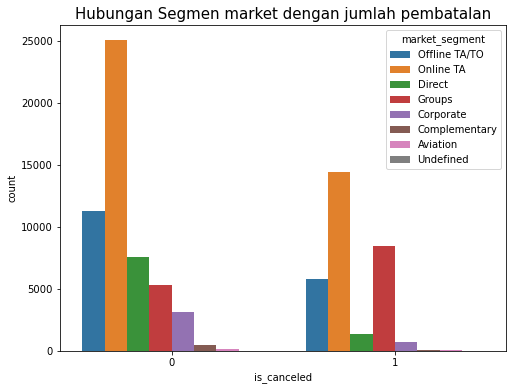

In [14]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'is_canceled', hue = 'market_segment', data = eda_hotel)
plt.title ('Hubungan Segmen market dengan jumlah pembatalan', size=15)

Text(0.5, 1.0, 'Hubungan Tipe ruangan yang dipesan dengan jumlah pembatalan')

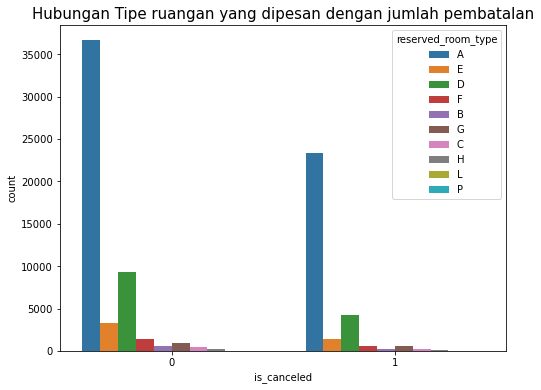

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'is_canceled', hue = 'reserved_room_type', data = eda_hotel)
plt.title ('Hubungan Tipe ruangan yang dipesan dengan jumlah pembatalan', size=15)

In [16]:
eda_hotel['total_of_special_requests'].value_counts()

0    49188
1    23214
2     9120
3     1784
4      236
5       31
Name: total_of_special_requests, dtype: int64

In [17]:
eda_hotel['requested'] = np.where(eda_hotel['total_of_special_requests'] == 0,0,1)
eda_hotel

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled,requested
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0,1
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0,1
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
83568,PRT,Online TA,0,0,No Deposit,0,Contract,A,0,3,1,1
83569,FRA,Online TA,0,0,No Deposit,0,Transient,D,0,2,0,1
83570,PRT,Online TA,0,1,No Deposit,0,Transient,D,0,3,0,1
83571,CN,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0,0


Text(0.5, 1.0, 'Hubungan spesial request yang dilakukan konsumen dengan jumlah pembatalan')

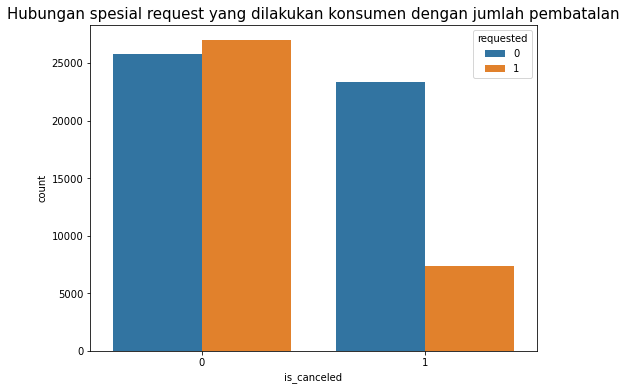

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(x = 'is_canceled', hue = 'requested', data = eda_hotel)
plt.title ('Hubungan spesial request yang dilakukan konsumen dengan jumlah pembatalan', size=15)

## Preprocessing Scheme


- Target : is_canceled
- OneHotEncoding : deposit_type, customer_type
- BinaryEncoder : country, market_segment, reserved_room_type
- SimpleImputer Mode : country
- passthrough : previous_cancellations, booking_changes, days_in_waiting_list, required_car_parking_spaces , total_of_special_requests

In [19]:
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


Sekarang mari kita melakukan fitur encoding untuk fitur2 categorical yang kita miliki.
Yang akan kita lakukan adalah :

1. Merubah fitur/kolom `country` menjadi integer 0-161 dengan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur baru yg terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
2. Merubah fitur/kolom `market_segment` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur baru yg terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.
3. Merubah fitur/kolom `deposit_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
4. Merubah fitur/kolom `customer_type` menggunakan One Hot Encoding, karena fitur ini tidak memiliki urutan/tidak ordinal, dan juga jumlah unique datanya hanya sedikit.
5. Merubah fitur/kolom `reserved_room_type` menggunakan Binary Encoding, karena fitur ini memiliki unique data yang banyak dan tidak memiliki urutan/tidak ordinal, bila kita menggunakan One Hot Encoding akan terlalu banyak fitur baru yg terbuat, dan kalau kita menggunakan Ordinal/Label Encoding hasilnya dapat kurang cocok/kurang baik. Oleh karena itu kita akan mencoba menggunakan Binary Encoding saja.

In [20]:
mode_imp = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('binary', BinaryEncoder())
])

transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(handle_unknown='ignore'), ['deposit_type', 'customer_type']),
    ('mod imp', mode_imp, ['country']),
    ('binary enc', BinaryEncoder(), ['market_segment', 'reserved_room_type'])
], remainder='passthrough')

In [21]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                    stratify=y,
                                                   test_size=0.2,
                                                    random_state=2022)

In [23]:
X_train.shape

(66858, 10)

## Modelling & Evaluation

In [24]:
logreg = LogisticRegression(random_state = 2022)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier (random_state = 2022)
rf = RandomForestClassifier(random_state=2022)
xgb = XGBClassifier(random_state=2022)
lgbm = lgb.LGBMClassifier(random_state=2022)
ada = AdaBoostClassifier(random_state=2022)

In [25]:
models = [logreg,knn,dt,rf,xgb,lgbm,ada]
score=[]
rata=[]
std=[]

for i in models:
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='f1', n_jobs=-1)
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost', 'LightGBM', 'AdaBoost'],'mean f1':rata,'sdev':std}).set_index('model').sort_values(by='mean f1',ascending=False)

,mean f1,sdev
model,,
XGBoost,0.728609,0.005609
LightGBM,0.725929,0.003376
Random Forest,0.724459,0.005403
Decision Tree,0.720411,0.005923
KNN,0.689226,0.016798
AdaBoost,0.662091,0.006999
Logistic Regression,0.651759,0.009199


Berdasarkan Initial Modelling ini, model XGBoost merupakan model dengan score Mean F1 Paling Tinggi dan juga nilai standard deviasi yang relatif lebih stabil dari model lainnya.

In [26]:
models = [logreg,knn,dt,rf,xgb,lgbm, ada]
score_f1 = []

def y_pred_func(i):
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',i)])
    X_train,X_test
    
    estimator.fit(X_train,y_train)
    return(estimator,estimator.predict(X_test),X_test)

for i,j in zip(models, ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM', 'AdaBoost']):
    estimator,y_pred,X_test = y_pred_func(i)
    y_predict = estimator.predict(X_test)
    score_f1.append(f1_score(y_test,y_predict))
    print(j,'\n', classification_report(y_test,y_pred))
    
pd.DataFrame({'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost','LightGBM', 'AdaBoost'],
             'f1 score':score_f1}).set_index('model').sort_values(by='f1 score',ascending=False)

Logistic Regression 
               precision    recall  f1-score   support

           0       0.78      0.92      0.84     10559
           1       0.79      0.56      0.65      6156

    accuracy                           0.78     16715
   macro avg       0.79      0.74      0.75     16715
weighted avg       0.78      0.78      0.77     16715

KNN 
               precision    recall  f1-score   support

           0       0.80      0.89      0.84     10559
           1       0.76      0.62      0.69      6156

    accuracy                           0.79     16715
   macro avg       0.78      0.76      0.76     16715
weighted avg       0.79      0.79      0.78     16715

Decision Tree 
               precision    recall  f1-score   support

           0       0.82      0.88      0.85     10559
           1       0.77      0.68      0.72      6156

    accuracy                           0.81     16715
   macro avg       0.80      0.78      0.79     16715
weighted avg       0.81      0

,f1 score
model,
XGBoost,0.736331
LightGBM,0.725597
Random Forest,0.725320
Decision Tree,0.721419
KNN,0.685857
AdaBoost,0.664297
Logistic Regression,0.653556


Terlihat kembali bahwa model XGBoost adalah yang terbaik performanya pada test data.

Kita akan mencoba menghandling imbalance data, kita akan melakukan Resampling dengan metode undersampling, oversampling dan gabungan dari keduanya.

## Handling Imbalance

In [27]:
df['is_canceled'].value_counts()/df.shape[0]*100

0    63.172316
1    36.827684
Name: is_canceled, dtype: float64

Proporsi data target menunjukan bahwa data tidak seimbang (Imbalance) sehingga selanjutnya kita akan membandingkan metode resampling oversampling, undersampling dan gabungan dari keduanya untuk mendapat kan hasil metric score yang terbaik.

In [28]:
ros = RandomOverSampler(random_state=2022)
rus = RandomUnderSampler(random_state=2022)
smote = SMOTE(random_state=2022)
smotetomek = SMOTETomek(random_state=2022) 

In [29]:
resamples = [ros,rus, smote,smotetomek]
score=[]
rata=[]
std=[]

for i, val in enumerate(resamples):
    skfold=StratifiedKFold(n_splits=5)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('resampling', val),
        ('model',xgb)])
    if i<2:
        X_under, y_under= val.fit_resample(X_train, y_train)
        model_cv=cross_val_score(estimator,X_under,y_under,cv=skfold,scoring='f1', n_jobs=-1)
    else:
        model_cv=cross_val_score(estimator,X_train,y_train,cv=skfold,scoring='f1', n_jobs=-1)
    
    
    score.append(model_cv)
    rata.append(model_cv.mean())
    std.append(model_cv.std())
    
pd.DataFrame({'resamples':['RandomOverSampler', 'RandomUnderSampler','SMOTE', 'SMOTETomek'],'mean f1':rata,'stddev':std}).set_index('resamples').sort_values(by='mean f1',ascending=False)

,mean f1,stddev
resamples,,
RandomOverSampler,0.798522,0.002948
RandomUnderSampler,0.795177,0.001740
SMOTE,0.742985,0.001190
SMOTETomek,0.742034,0.001645


Berdasarkan Perbandingan dari metode Resampling yang digunakan, metode Random Over Sampler menunjukan peningkatan Score mean F1 yang cukup signifikan dari nilai awal, walaupun begitu nilai standard deviasi yang relatif tinggi apabila dibandingkan dengan metode Resampling lainnya menunjukan bahwa nilai F1 masih belum stabil.
Sehingga kita akan mencoba membandingkan nilai training dan testing untuk mencoba mendapatkan insight lebih lanjut.

## OverSampling Test with K-Fold Cross Validation

In [30]:
def calc_train_error(X_train, y_train, model):
#     '''returns in-sample error for already fit model.'''
    predictions = model.predict(X_train)
    predictProba = model.predict_proba(X_train)
    accuracy = accuracy_score(y_train, predictions)
    f1 = f1_score(y_train, predictions, average='macro')
    roc_auc = roc_auc_score(y_train, predictProba[:,1])
    recall = recall_score(y_train, predictions)
    precision = precision_score(y_train, predictions)
    report = classification_report(y_train, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_validation_error(X_test, y_test, model):
#     '''returns out-of-sample error for already fit model.'''
    predictions = model.predict(X_test)
    predictProba = model.predict_proba(X_test)
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions, average='macro')
    roc_auc = roc_auc_score(y_test, predictProba[:,1])
    recall = recall_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    report = classification_report(y_test, predictions)
    return { 
        'report': report, 
        'f1' : f1, 
        'roc': roc_auc, 
        'accuracy': accuracy,
        'recall': recall,
        'precision': precision
    }
    
def calc_metrics(X_train, y_train, X_test, y_test, model):
#     '''fits model and returns the in-sample error and out-of-sample error'''
    model.fit(X_train, y_train)
    train_error = calc_train_error(X_train, y_train, model)
    validation_error = calc_validation_error(X_test, y_test, model)
    return train_error, validation_error

In [31]:
K = 10
kf = StratifiedKFold(n_splits=K, shuffle=True, random_state=42)

In [32]:
data = X_train
target = y_train

In [33]:
train_errors_without_oversampling = []
validation_errors_without_oversampling = []

train_errors_with_oversampling = []
validation_errors_with_oversampling = []

for train_index, val_index in kf.split(data, target):
    
    # split data
    X_train, X_val = data.iloc[train_index], data.iloc[val_index]
    Y_train, Y_val = target.iloc[train_index], target.iloc[val_index]
    
#     print(len(X_val), (len(X_train) + len(X_val)))
    ros = RandomOverSampler(random_state=2022)

    X_ros, Y_ros = ros.fit_resample(X_train, Y_train)

    # instantiate model
    xgb = XGBClassifier(random_state=2022)
    estimator=Pipeline([
        ('preprocess',transformer),
        ('model',xgb)
    ])

    #calculate errors
    train_error_without_oversampling, val_error_without_oversampling = calc_metrics(X_train, Y_train, X_val, Y_val, estimator)
    train_error_with_oversampling, val_error_with_oversampling = calc_metrics(X_ros, Y_ros, X_val, Y_val, estimator)
    
    # append to appropriate list
    train_errors_without_oversampling.append(train_error_without_oversampling)
    validation_errors_without_oversampling.append(val_error_without_oversampling)
    
    train_errors_with_oversampling.append(train_error_with_oversampling)
    validation_errors_with_oversampling.append(val_error_with_oversampling)

### Evaluation Metrics Without OverSampling

In [34]:
listItem = []

for tr,val in zip(train_errors_without_oversampling,validation_errors_without_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.816393,0.811995,0.900941,0.893075,0.797707,0.793131,0.695758,0.692526,0.781687,0.773243
1,0.815712,0.817380,0.900017,0.899495,0.797619,0.800153,0.701534,0.711210,0.776485,0.774436
2,0.815562,0.814837,0.899942,0.896054,0.795198,0.794313,0.679152,0.677498,0.790524,0.789773
3,0.814515,0.819623,0.898622,0.898277,0.795094,0.801662,0.687861,0.704305,0.782214,0.783906
4,0.816892,0.809004,0.900337,0.892047,0.796427,0.786678,0.678610,0.659220,0.794233,0.787482
5,0.818254,0.804367,0.901806,0.888827,0.797952,0.782546,0.680551,0.662063,0.796335,0.773979
6,0.816360,0.808705,0.900806,0.893003,0.797380,0.789427,0.692856,0.686967,0.783436,0.769091
7,0.816709,0.811098,0.901138,0.892231,0.798890,0.792999,0.704725,0.699553,0.776838,0.767142
8,0.816296,0.807928,0.900450,0.890724,0.796446,0.786021,0.684296,0.662470,0.788888,0.782630
9,0.815366,0.819895,0.899989,0.899001,0.797058,0.801699,0.699233,0.701868,0.777081,0.786169


### Evaluation Metrics With OverSampling

In [35]:
listItem = []

for tr,val in zip(train_errors_with_oversampling,validation_errors_with_oversampling) :
    listItem.append([tr['accuracy'],val['accuracy'],tr['roc'],val['roc'],tr['f1'],val['f1'],
                     tr['recall'],val['recall'],tr['precision'],val['precision']])

listItem.append(list(np.mean(listItem,axis=0)))
    
dfEvaluate = pd.DataFrame(listItem, 
                    columns=['Train Accuracy', 
                            'Test Accuracy', 
                            'Train ROC AUC', 
                            'Test ROC AUC', 
                            'Train F1 Score',
                            'Test F1 Score',
                            'Train Recall',
                            'Test Recall',
                            'Train Precision',
                            'Test Precision'])

listIndex = list(dfEvaluate.index)
listIndex[-1] = 'Average'
dfEvaluate.index = listIndex
dfEvaluate

,Train Accuracy,Test Accuracy,Train ROC AUC,Test ROC AUC,Train F1 Score,Test F1 Score,Train Recall,Test Recall,Train Precision,Test Precision
0,0.806443,0.791505,0.903944,0.891912,0.806439,0.782283,0.811033,0.795288,0.803655,0.687500
1,0.804522,0.799880,0.901604,0.899097,0.804522,0.791243,0.805298,0.809911,0.804050,0.696229
2,0.804838,0.796141,0.902200,0.895312,0.804837,0.786065,0.802273,0.786353,0.806410,0.698161
3,0.803417,0.799880,0.900612,0.897365,0.803416,0.790118,0.800721,0.793258,0.805063,0.702013
4,0.805219,0.797338,0.902676,0.892429,0.805215,0.787637,0.809955,0.792445,0.802356,0.698032
5,0.805496,0.791654,0.903519,0.889572,0.805494,0.782867,0.808218,0.801787,0.803841,0.685655
6,0.804856,0.791654,0.902154,0.892436,0.804854,0.782758,0.808434,0.799838,0.802690,0.686411
7,0.804527,0.795393,0.902399,0.891059,0.804527,0.785955,0.803804,0.794559,0.804969,0.694218
8,0.803133,0.797158,0.900669,0.889250,0.803122,0.786053,0.795570,0.772949,0.807789,0.704815
9,0.803738,0.809723,0.902239,0.898412,0.803737,0.799930,0.805803,0.798944,0.802489,0.716837


#### Classification Reports Without Oversampling

In [36]:
for rep in validation_errors_without_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.83      0.88      0.86      4224
           1       0.77      0.69      0.73      2462

    accuracy                           0.81      6686
   macro avg       0.80      0.79      0.79      6686
weighted avg       0.81      0.81      0.81      6686

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4224
           1       0.77      0.71      0.74      2462

    accuracy                           0.82      6686
   macro avg       0.81      0.80      0.80      6686
weighted avg       0.82      0.82      0.82      6686

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      4224
           1       0.79      0.68      0.73      2462

    accuracy                           0.81      6686
   macro avg       0.81      0.79      0.79      6686
weighted avg       0.81      0.81      0.81      6686

              preci

#### Classification Reports With Oversampling

In [37]:
for rep in validation_errors_with_oversampling :
    print(rep['report'])

              precision    recall  f1-score   support

           0       0.87      0.79      0.83      4224
           1       0.69      0.80      0.74      2462

    accuracy                           0.79      6686
   macro avg       0.78      0.79      0.78      6686
weighted avg       0.80      0.79      0.79      6686

              precision    recall  f1-score   support

           0       0.88      0.79      0.83      4224
           1       0.70      0.81      0.75      2462

    accuracy                           0.80      6686
   macro avg       0.79      0.80      0.79      6686
weighted avg       0.81      0.80      0.80      6686

              precision    recall  f1-score   support

           0       0.87      0.80      0.83      4224
           1       0.70      0.79      0.74      2462

    accuracy                           0.80      6686
   macro avg       0.78      0.79      0.79      6686
weighted avg       0.80      0.80      0.80      6686

              preci

## Hyperparameter Tuning

In [38]:
X = df.drop('is_canceled', axis=1)
y = df['is_canceled']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                   y,
                                                    stratify=y,
                                                   test_size=0.2,
                                                    random_state=2022)

In [40]:
estimator = Pipeline([
    ('preprocess', transformer),
    ('oversampling', ros),
    ('model', xgb)
])

In [42]:
hyperparam_space = [{
    'oversampling__sampling_strategy' : ['minority', 'not minority'],
    'model__eta' : [0.3, 0.4, 0.5, 0.6, 0.7],
    'model__gamma' : [0, 1, 2, 3, 4, 5],
    'model__max_depth' : [3, 4, 5, 6, 7, 8, 9],
    'model__min_child_weight' : [1, 2, 3, 4, 5]
}]

In [43]:
random = RandomizedSearchCV(
            estimator=estimator,
            param_distributions = hyperparam_space,
            cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state =2022),
            scoring = 'f1',
            n_iter = 10,
            n_jobs = -1)

random.fit(X_train, y_train)

print ('best score', random.best_score_)
print ('best_param', random.best_params_)

best score 0.7420039974279247
best_param {'oversampling__sampling_strategy': 'minority', 'model__min_child_weight': 4, 'model__max_depth': 8, 'model__gamma': 1, 'model__eta': 0.6}


In [44]:
grid = GridSearchCV(
    estimator=estimator, 
    n_jobs=-1, 
    param_grid=hyperparam_space, 
    scoring='f1', 
    cv=StratifiedKFold(n_splits=5, shuffle = True, random_state =2022))

In [ ]:
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_score_)
print(grid.best_params_)